# Loading packages


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
import pandas as pd
import PIL.Image
import collections

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Loading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [101]:
all_info = pd.read_csv("/content/drive/MyDrive/GitHub_Projects/plane_variants/img/all_info.csv")
all_info.sample(10)

,long_model,airline,photo_date,uploaded_date,location,uploader,photo_link,download_path,model,variant
8127,Airbus A350-941,Lufthansa,Photo date: 2021-03-24,Uploaded: 2021-04-04,Location: Frankfurt Rhein-Main Int'l Airport -...,By: Manuel Mueller,cdn.jetphotos.com/400/6/52786_1616687744.jpg,./img/A350/cdn.jetphotos.com-400-6-52786_16166...,A350,941
16104,Boeing 777-F1H,Emirates SkyCargo,Photo date: 2021-05-10,Uploaded: 2021-05-21,"Location: Guangzhou Baiyun Airport - ZGGG, China",By: Ame_Jayzz,cdn.jetphotos.com/400/5/22747_1620741489.jpg,./img/B777/cdn.jetphotos.com-400-5-22747_16207...,B777,F1H
4314,Airbus A340-313X,Plus Ultra Líneas Aéreas,Photo date: 2021-05-03,Uploaded: 2021-05-17,Location: Brussels Zaventem Int'l Airport - EB...,By: Matteo Lamberts,cdn.jetphotos.com/400/5/17000_1620502051.jpg,./img/A340/cdn.jetphotos.com-400-5-17000_16205...,A340,313X
5466,Airbus A340-313X,Germany - Air Force,Photo date: 2017-04-02,Uploaded: 2021-01-16,"Location: München Franz Josef Strauß - EDDM, G...",By: Benjamin Exenberger,cdn.jetphotos.com/400/5/96293_1610295123.jpg,./img/A340/cdn.jetphotos.com-400-5-96293_16102...,A340,313X
4952,Airbus A340-313E,South African Airways,Photo date: 2020-02-16,Uploaded: 2021-03-04,"Location: München Franz Josef Strauß - EDDM, G...",By: Roland Brei - RFotomoments,cdn.jetphotos.com/400/5/14696_1614199778.jpg,./img/A340/cdn.jetphotos.com-400-5-14696_16141...,A340,313E
1798,Airbus A320-214,Aeroflot,Photo date: 2021-05-09,Uploaded: 2021-05-27,"Location: München Franz Josef Strauß - EDDM, G...",By: Hugo Schwarzer,cdn.jetphotos.com/400/6/49770_1621147817.jpg,./img/A320/cdn.jetphotos.com-400-6-49770_16211...,A320,214
10784,Boeing 737-85P,Air Europa,Photo date: 2021-05-26,Uploaded: 2021-06-12,"Location: Gdansk-Rebiechowo - EPGD, Poland",By: Filip Danielczyk,cdn.jetphotos.com/400/6/73169_1622406923.jpg,./img/B737/cdn.jetphotos.com-400-6-73169_16224...,B737,85P
9661,Airbus A380-842,Emirates,Photo date: 2020-11-04,Uploaded: 2020-11-16,"Location: London Heathrow Int'l - EGLL, United...",By: Nick Farrington,cdn.jetphotos.com/400/5/62143_1604850625.jpg,./img/A380/cdn.jetphotos.com-400-5-62143_16048...,A380,842
4876,Airbus A340-313X,Eurowings (Brussels Airlines),Photo date: 2018-04-19,Uploaded: 2021-03-13,"Location: Milano Malpensa - LIMC, Italy",By: Maurizio Riva,cdn.jetphotos.com/400/5/18217_1614892188.jpg,./img/A340/cdn.jetphotos.com-400-5-18217_16148...,A340,313X
8130,Airbus A350-941,China Southern Airlines,Photo date: 2021-03-24,Uploaded: 2021-04-04,"Location: Shanghai-Hongqiao - ZSSS, China",By: Michael Tang,cdn.jetphotos.com/400/5/30961_1616673538.jpg,./img/A350/cdn.jetphotos.com-400-5-30961_16166...,A350,941


In [113]:
all_info.loc[:, "download_path"] = all_info.download_path.str.replace("\\./", "/content/drive/MyDrive/GitHub_Projects/plane_variants/")
all_info_rows = all_info.shape[0]
np.random.seed(10)
all_info["purpose"] = np.random.choice(["train", "test", "validation"], size=all_info_rows, replace=True, p=[0.64, 0.16, 0.2])
a380vb747 = all_info.loc[all_info.model.isin(["A380", "B747"])].reset_index()
a380vb747.head()

,index,long_model,airline,photo_date,uploaded_date,location,uploader,photo_link,download_path,model,variant,purpose
0,8320,Airbus A380-861,Emirates,Photo date: 2021-05-30,Uploaded: 2021-06-15,Location: Manchester Ringway Int'l Airport - E...,By: Paul Spijkers,cdn.jetphotos.com/400/5/68077_1622647548.jpg,/content/drive/MyDrive/GitHub_Projects/plane_v...,A380,861,train
1,8321,Airbus A380-861,Emirates,Photo date: 2021-04-10,Uploaded: 2021-06-15,"Location: Guangzhou Baiyun Airport - ZGGG, China",By: ChaleLu,cdn.jetphotos.com/400/6/75937_1622641760.jpg,/content/drive/MyDrive/GitHub_Projects/plane_v...,A380,861,test
2,8322,Airbus A380-841,China Southern Airlines,Photo date: 2021-05-19,Uploaded: 2021-06-15,"Location: Guangzhou Baiyun Airport - ZGGG, China",By: Fang Xiaoyu,cdn.jetphotos.com/400/6/74070_1622628386.jpg,/content/drive/MyDrive/GitHub_Projects/plane_v...,A380,841,validation
3,8323,Airbus A380-841,Singapore Airlines,Photo date: 2019-09-02,Uploaded: 2021-06-15,"Location: Zurich-Kloten Airport - LSZH, Switze...",By: Nguyen Huy Bao,cdn.jetphotos.com/400/5/32090_1622625012.jpg,/content/drive/MyDrive/GitHub_Projects/plane_v...,A380,841,train
4,8324,Airbus A380-841,British Airways,Photo date: 2019-04-19,Uploaded: 2021-06-15,"Location: London Heathrow Int'l - EGLL, United...",By: Simon Fewkes,cdn.jetphotos.com/400/5/60639_1622620557.jpg,/content/drive/MyDrive/GitHub_Projects/plane_v...,A380,841,validation


In [114]:
train_df = a380vb747.loc[a380vb747.purpose == "train"]
test_df = a380vb747.loc[a380vb747.purpose == "test"]
validation_df = a380vb747.loc[a380vb747.purpose == "validation"]
print(train_df.download_path.head())

0    /content/drive/MyDrive/GitHub_Projects/plane_v...
3    /content/drive/MyDrive/GitHub_Projects/plane_v...
6    /content/drive/MyDrive/GitHub_Projects/plane_v...
7    /content/drive/MyDrive/GitHub_Projects/plane_v...
8    /content/drive/MyDrive/GitHub_Projects/plane_v...
Name: download_path, dtype: object


In [115]:
train_df.download_path[0]

'/content/drive/MyDrive/GitHub_Projects/plane_variants/img/A380/cdn.jetphotos.com-400-5-68077_1622647548.jpg'

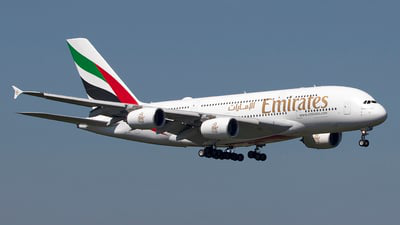

In [116]:
PIL.Image.open(str(train_df.download_path[0]))

In [117]:
def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_fn)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_fn)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_fn)

IMG_SIZE = (225, 400)

train_dataset = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="download_path",
    y_col="model",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1234)

test_dataset = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col="download_path",
    y_col="model",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1234)

validation_dataset = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=None,
    x_col="download_path",
    y_col="model",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1234)

Found 2634 validated image filenames belonging to 2 classes.
Found 681 validated image filenames belonging to 2 classes.
Found 845 validated image filenames belonging to 2 classes.


In [118]:
print(collections.Counter(train_dataset.labels))

Counter({0: 1326, 1: 1308})


In [119]:
train_dataset[0][0].shape

(32, 225, 400, 3)

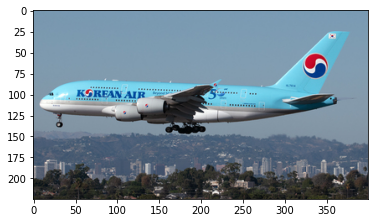

In [120]:
plt.imshow(((train_dataset[0][0][0,:,:,:])+1)/2)
plt.show()

In [121]:
print(np.max(train_dataset[0][0][0,:,:,:]))
print(np.min(train_dataset[0][0][0,:,:,:]))

1.0
-1.0


In [122]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [123]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 13, 1280)


# Feature extraction

In [124]:
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 225, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 113, 200, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 113, 200, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 113, 200, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [125]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [126]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=(225, 400, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [127]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 225, 400, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 225, 400, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 13, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Initial training

In [128]:
initial_epochs = 3

loss0, accuracy0 = model.evaluate(validation_dataset)

27/27 [==============================] - 160s 6s/step - loss: 0.7381 - accuracy: 0.4828


In [129]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/3
83/83 [==============================] - 558s 7s/step - loss: 0.7360 - accuracy: 0.4909 - val_loss: 0.6997 - val_accuracy: 0.4828
Epoch 2/3
83/83 [==============================] - 190s 2s/step - loss: 0.7242 - accuracy: 0.5148 - val_loss: 0.6969 - val_accuracy: 0.4828
Epoch 3/3
83/83 [==============================] - 188s 2s/step - loss: 0.7187 - accuracy: 0.5197 - val_loss: 0.6918 - val_accuracy: 0.4828


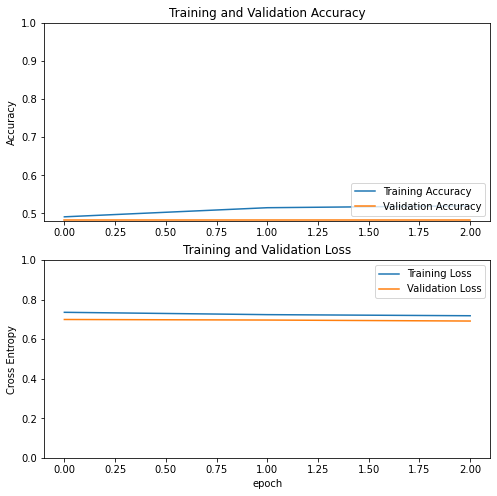

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

In [131]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Number of layers in the base model:  154
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 225, 400, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 225, 400, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 13, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


56

In [132]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 3/13
83/83 [==============================] - 312s 4s/step - loss: 0.6855 - accuracy: 0.5418 - val_loss: 0.6381 - val_accuracy: 0.4911
Epoch 4/13
83/83 [==============================] - 306s 4s/step - loss: 0.6475 - accuracy: 0.5774 - val_loss: 0.5935 - val_accuracy: 0.7266
Epoch 5/13
83/83 [==============================] - 306s 4s/step - loss: 0.6116 - accuracy: 0.6333 - val_loss: 0.5606 - val_accuracy: 0.7645
Epoch 6/13
83/83 [==============================] - 303s 4s/step - loss: 0.5709 - accuracy: 0.6648 - val_loss: 0.5046 - val_accuracy: 0.7704
Epoch 7/13
83/83 [==============================] - 303s 4s/step - loss: 0.5426 - accuracy: 0.6834 - val_loss: 0.4780 - val_accuracy: 0.7136
Epoch 8/13
83/83 [==============================] - 302s 4s/step - loss: 0.5166 - accuracy: 0.7134 - val_loss: 0.4977 - val_accuracy: 0.6485
Epoch 9/13
83/83 [==============================] - 304s 4s/step - loss: 0.5003 - accuracy: 0.7172 - val_loss: 0.4714 - val_accuracy: 0.7669
Epoch 10/13
8

In [133]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs+20,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=validation_dataset)

Epoch 13/33
83/83 [==============================] - 308s 4s/step - loss: 0.4245 - accuracy: 0.7775 - val_loss: 0.4083 - val_accuracy: 0.8095
Epoch 14/33
83/83 [==============================] - 305s 4s/step - loss: 0.4150 - accuracy: 0.7844 - val_loss: 0.3692 - val_accuracy: 0.8154
Epoch 15/33
83/83 [==============================] - 305s 4s/step - loss: 0.3966 - accuracy: 0.7950 - val_loss: 0.4076 - val_accuracy: 0.7361
Epoch 16/33
83/83 [==============================] - 305s 4s/step - loss: 0.3866 - accuracy: 0.7961 - val_loss: 0.3739 - val_accuracy: 0.8426
Epoch 17/33
83/83 [==============================] - 304s 4s/step - loss: 0.3700 - accuracy: 0.8151 - val_loss: 0.4392 - val_accuracy: 0.7219
Epoch 18/33
83/83 [==============================] - 303s 4s/step - loss: 0.3692 - accuracy: 0.8136 - val_loss: 0.3765 - val_accuracy: 0.8497
Epoch 19/33
83/83 [==============================] - 304s 4s/step - loss: 0.3562 - accuracy: 0.8292 - val_loss: 0.3852 - val_accuracy: 0.7467
Epoch 

In [137]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.45, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

TypeError: ignored

In [138]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

22/22 [==============================] - 37s 2s/step - loss: 0.2778 - accuracy: 0.8825
Test accuracy : 0.8825256824493408


In [139]:
model.save('/content/a380vb787_dataframemodel')

INFO:tensorflow:Assets written to: /content/a380vb787_dataframemodel/assets


In [140]:
!zip -r /content/a380vb787_dataframemodel.zip /content/a380vb787_dataframemodel/

  adding: content/a380vb787_dataframemodel/ (stored 0%)
  adding: content/a380vb787_dataframemodel/keras_metadata.pb (deflated 96%)
  adding: content/a380vb787_dataframemodel/variables/ (stored 0%)
  adding: content/a380vb787_dataframemodel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/a380vb787_dataframemodel/variables/variables.index (deflated 77%)
  adding: content/a380vb787_dataframemodel/assets/ (stored 0%)
  adding: content/a380vb787_dataframemodel/saved_model.pb (deflated 92%)
